In [40]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from itertools import cycle

# colors generator
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [41]:
sales_s = pd.read_pickle("../Documents/Forecasting_Project/sales_s.pkl")
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


In [42]:
sales_s_p64 = sales_s[['P_64']]
sales_s_p64

,P_64
2014-07-31,1039
2014-08-31,1134
2014-09-30,1160
2014-10-31,1180
2014-11-30,1065
...,...
2019-05-31,1634
2019-06-30,1597
2019-07-31,1560
2019-08-31,1817


In [43]:
sales_s_p64['year'] = sales_s_p64.index.year
sales_s_p64['month'] = sales_s_p64.index.month
sales_s_p64['quarter'] = sales_s_p64.index.quarter
sales_s_p64

<ipython-input-43-93c976de6b8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['year'] = sales_s_p64.index.year
<ipython-input-43-93c976de6b8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['month'] = sales_s_p64.index.month
<ipython-input-43-93c976de6b8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,P_64,year,month,quarter
2014-07-31,1039,2014,7,3
2014-08-31,1134,2014,8,3
2014-09-30,1160,2014,9,3
2014-10-31,1180,2014,10,4
2014-11-30,1065,2014,11,4
...,...,...,...,...
2019-05-31,1634,2019,5,2
2019-06-30,1597,2019,6,2
2019-07-31,1560,2019,7,3
2019-08-31,1817,2019,8,3


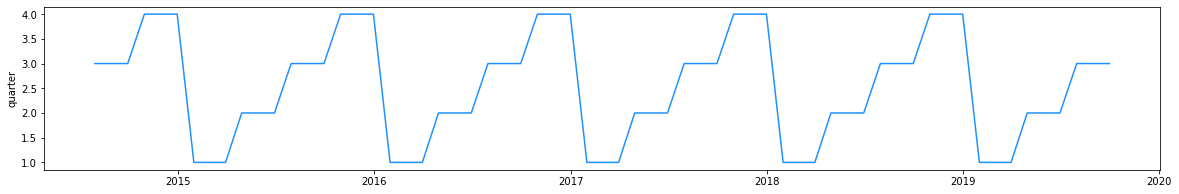

In [44]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=sales_s_p64.index, y=sales_s_p64['quarter'], color='dodgerblue')
# ax.set_xlim([date(2014, 7, 31), date(2019, 9, 30)])
plt.show()

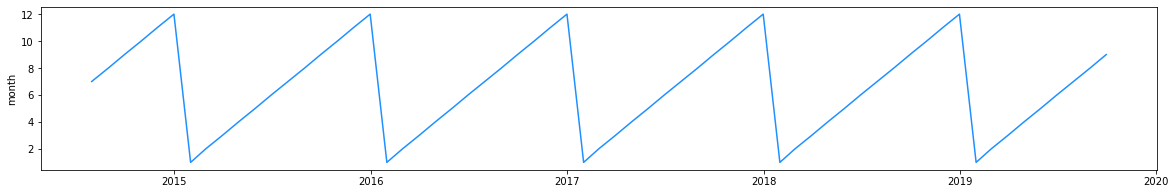

In [45]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=sales_s_p64.index, y=sales_s_p64['month'], color='dodgerblue')
# ax.set_xlim([date(2014, 7, 31), date(2019, 9, 30)])
plt.show()

<ipython-input-46-71a3e500bd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['month_sin'] = np.sin(2*np.pi*sales_s_p64['month']/month_in_year)
<ipython-input-46-71a3e500bd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['month_cos'] = np.cos(2*np.pi*sales_s_p64['month']/month_in_year)


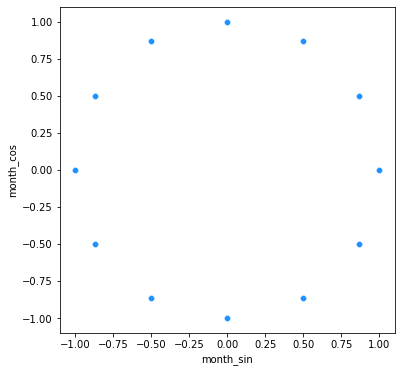

In [46]:
month_in_year = 12
sales_s_p64['month_sin'] = np.sin(2*np.pi*sales_s_p64['month']/month_in_year)
sales_s_p64['month_cos'] = np.cos(2*np.pi*sales_s_p64['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=sales_s_p64.month_sin, y=sales_s_p64.month_cos, color='dodgerblue')
plt.show()

In [47]:
sales_s_p64

,P_64,year,month,quarter,month_sin,month_cos
2014-07-31,1039,2014,7,3,-5.000000e-01,-8.660254e-01
2014-08-31,1134,2014,8,3,-8.660254e-01,-5.000000e-01
2014-09-30,1160,2014,9,3,-1.000000e+00,-1.836970e-16
2014-10-31,1180,2014,10,4,-8.660254e-01,5.000000e-01
2014-11-30,1065,2014,11,4,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...
2019-05-31,1634,2019,5,2,5.000000e-01,-8.660254e-01
2019-06-30,1597,2019,6,2,1.224647e-16,-1.000000e+00
2019-07-31,1560,2019,7,3,-5.000000e-01,-8.660254e-01
2019-08-31,1817,2019,8,3,-8.660254e-01,-5.000000e-01


<ipython-input-48-6d6acf2eb8a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['quarter_sin'] = np.sin(2*np.pi*sales_s_p64['quarter']/month_quarter)
<ipython-input-48-6d6acf2eb8a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_s_p64['quarter_cos'] = np.cos(2*np.pi*sales_s_p64['quarter']/month_quarter)


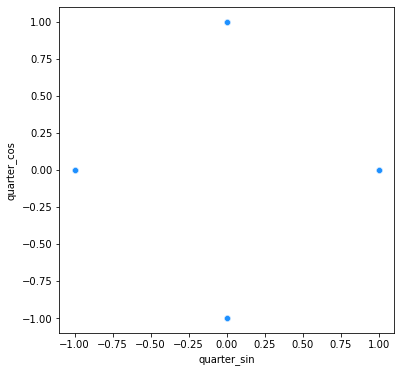

In [48]:
month_quarter =4
sales_s_p64['quarter_sin'] = np.sin(2*np.pi*sales_s_p64['quarter']/month_quarter)
sales_s_p64['quarter_cos'] = np.cos(2*np.pi*sales_s_p64['quarter']/month_quarter)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=sales_s_p64.quarter_sin, y=sales_s_p64.quarter_cos, color='dodgerblue')
plt.show()

In [49]:
sales_s_p64['lag1'] = sales_s_p64.P_64.shift(1)
sales_s_p64['lag2'] = sales_s_p64.P_64.shift(2)
sales_s_p64['lag3'] = sales_s_p64.P_64.shift(3)
sales_s_p64['lag4'] = sales_s_p64.P_64.shift(4)

<AxesSubplot:>

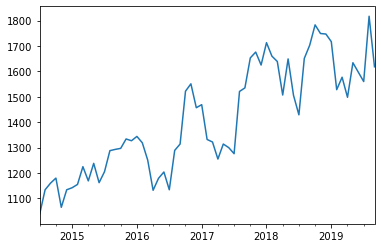

In [50]:
sales_s_p64.P_64.plot()

In [51]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

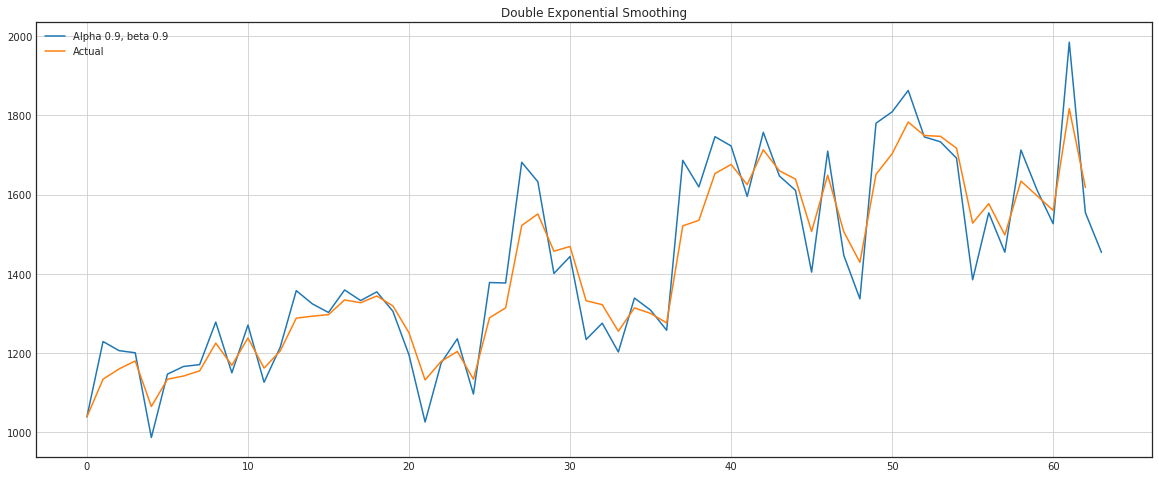

In [52]:
plotDoubleExponentialSmoothing(sales_s.P_64, alphas=[0.9], betas=[0.9])


Text(0.5, 1.0, 'Double Exponential Smoothing')

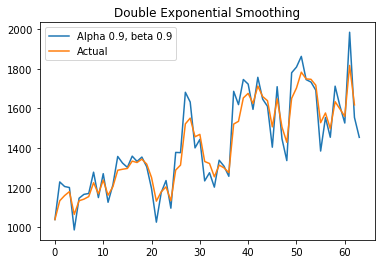

In [53]:
double_exp_P64 = double_exponential_smoothing(sales_s.P_64, alpha=0.9, beta=0.9)
plt.plot(double_exp_P64, label="Alpha {}, beta {}".format(0.9, 0.9))
plt.plot(sales_s.P_64.values, label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Double Exponential Smoothing")

In [54]:
# sales_s_p64['double_exp_P64']=double_exp_P64[:-1]

In [55]:
sales_s_p64

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos,lag1,lag2,lag3,lag4
2014-07-31,1039,2014,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,NaN,NaN,NaN,NaN
2014-08-31,1134,2014,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1039.0,NaN,NaN,NaN
2014-09-30,1160,2014,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,1134.0,1039.0,NaN,NaN
2014-10-31,1180,2014,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,1160.0,1134.0,1039.0,NaN
2014-11-30,1065,2014,11,4,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,1180.0,1160.0,1134.0,1039.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,1634,2019,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1498.0,1577.0,1528.0,1717.0
2019-06-30,1597,2019,6,2,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,1634.0,1498.0,1577.0,1528.0
2019-07-31,1560,2019,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,1597.0,1634.0,1498.0,1577.0
2019-08-31,1817,2019,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1560.0,1597.0,1634.0,1498.0


In [56]:
sales_s_p64[['P_64']]

,P_64
2014-07-31,1039
2014-08-31,1134
2014-09-30,1160
2014-10-31,1180
2014-11-30,1065
...,...
2019-05-31,1634
2019-06-30,1597
2019-07-31,1560
2019-08-31,1817


In [57]:
data = pd.DataFrame(sales_s_p64[['P_64', 'lag1', 'lag2', 'lag3', 'lag4']])
for i in range(5, 13):
    data[f"lag{i}"] = data.P_64.shift(i)

In [58]:
data

,P_64,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
2014-07-31,1039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,1134,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,1160,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,1180,1160.0,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,1065,1180.0,1160.0,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,1634,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0,1649.0
2019-06-30,1597,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0
2019-07-31,1560,1597.0,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0
2019-08-31,1817,1560.0,1597.0,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0


In [59]:
from sklearn.model_selection import TimeSeriesSplit

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [61]:
y = sales_s_p64.P_64
y

2014-07-31    1039
2014-08-31    1134
2014-09-30    1160
2014-10-31    1180
2014-11-30    1065
              ... 
2019-05-31    1634
2019-06-30    1597
2019-07-31    1560
2019-08-31    1817
2019-09-30    1618
Name: P_64, Length: 63, dtype: int64

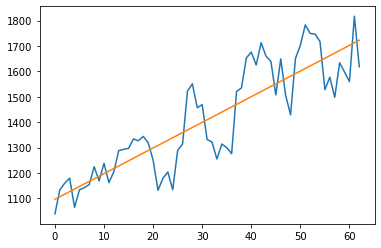

In [62]:
y = sales_s_p64.P_64
lr = LinearRegression()
t = np.array([i for i in range(len(y))])
t = np.reshape(t, (len(t), 1))
y = y.values
lr.fit(t, y)
trend = lr.predict(t)
plt.plot(y)
plt.plot(trend)

In [63]:

# Perform the Dickey Fuller Test
dftest = adfuller(y-trend, regression='nc', autolag='AIC')
# Print Dickey-Fuller test results
print ('Results of Dickey-Fuller Test:')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                 -2.550376
p-value                         0.010414
#Lags Used                      6.000000
Number of Observations Used    56.000000
Critical Value (1%)            -2.606822
Critical Value (5%)            -1.946692
Critical Value (10%)           -1.612798
dtype: float64


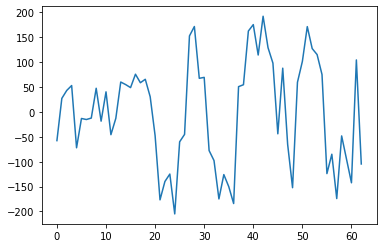

In [64]:
plt.plot(y-trend)

In [65]:
test = [i**2-i + 6 for i in range(100)]

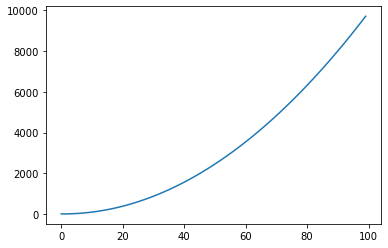

In [66]:
plt.plot(test)

<AxesSubplot:>

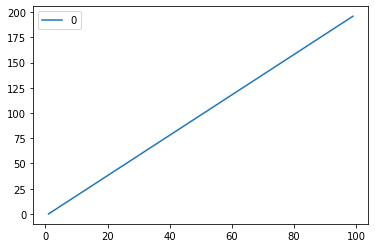

In [67]:
pd.DataFrame(test).diff(1).plot()

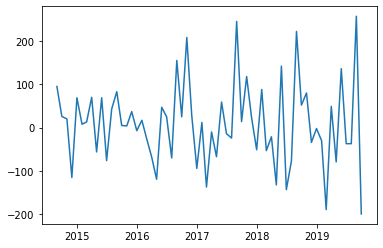

In [68]:
plt.plot(sales_s_p64.P_64.diff(1))

In [69]:
print('intercept:', lr.intercept_)
print('slope:', lr.coef_)

intercept: 1096.6071428571431
slope: [10.09562212]


In [70]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [71]:
y = data.dropna().P_64
X = data.dropna().drop(['P_64'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [72]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

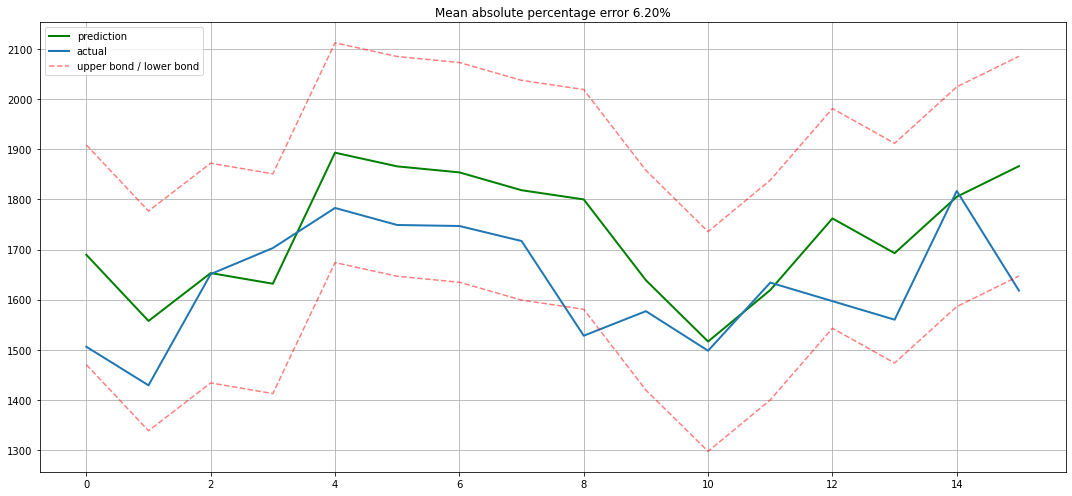

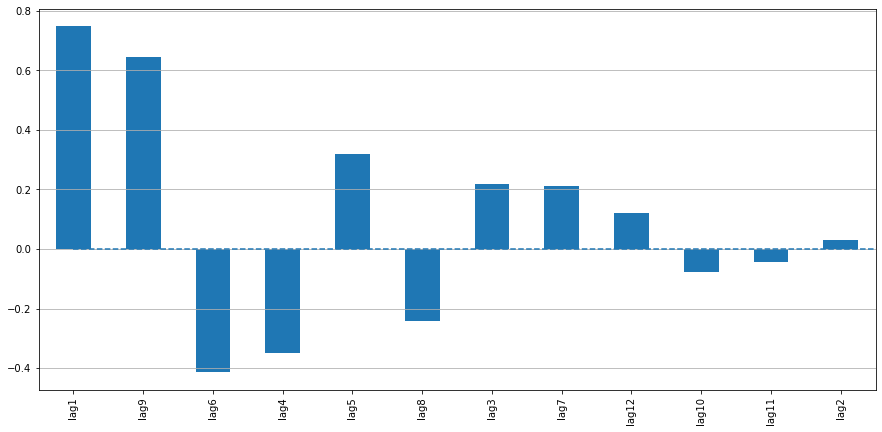

In [74]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)